# Part 1: Data Exploration and Preprocessing

In this notebook, you will implement functions to load, preprocess, and visualize physiological data from the Wearable Exam Stress Dataset.

In [22]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import os

# Set style for plots
print(plt.style.available)

plt.style.use('seaborn-v0_8')
%matplotlib inline

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


## 1. Data Loading

Implement the `load_data` function to read and organize the physiological data from the dataset.

In [77]:
def load_data(data_dir='data/raw'):
    """Load and organize the physiological data from the dataset.
    
    Parameters
    ----------
    data_dir : str
        Path to the directory containing the dataset files
        
    Returns
    -------
    pd.DataFrame
        DataFrame containing the organized physiological data with columns:
        ['timestamp', 'heart_rate', 'eda', 'temperature', 'subject_id', 'session']
    """

    data_list = []

    # Loop through subjects (S1, S2, ..., S10)
    for subject_folder in os.listdir(data_dir):
        subject_path = os.path.join(data_dir, subject_folder)
        
        if os.path.isdir(subject_path):
            # Loop through sessions: 'Midterm 1', 'Midterm 2', 'Final'
            for session_name in ['Midterm 1', 'Midterm 2', 'Final']:
                session_path = os.path.join(subject_path, session_name)
                
                if os.path.isdir(session_path):
                    # Load the data from the CSV files
                    temp_data = pd.read_csv(os.path.join(session_path, 'TEMP.csv'))
                    eda_data = pd.read_csv(os.path.join(session_path, 'EDA.csv'))
                    hr_data = pd.read_csv(os.path.join(session_path, 'HR.csv'))
                    
                    # Extract initial time and sampling rate
                    initial_time = pd.to_datetime(temp_data.iloc[0, 0], unit='s')
                    sampling_rate = temp_data.iloc[1, 0]  # This will be used later for resampling if needed
                    
                    # Data starts from row 2 onwards (skipping the initial time and sample rate rows)
                    timestamps = pd.to_datetime(temp_data.iloc[2:, 0], unit='s')  # Timestamps are Unix time
                    temperature = temp_data.iloc[2:, 0].values
                    eda = eda_data.iloc[2:, 0].values
                    heart_rate = hr_data.iloc[2:, 0].values
                    
                    #print(len(timestamps))
                    #print(len(temperature))
                    #print(len(eda))
                    #print(len(heart_rate))
                    #print(len(subject_folder))

                    min_length = min(len(temperature), len(eda), len(heart_rate))
                    temperature = temperature[:min_length]
                    eda = eda[:min_length]
                    heart_rate = heart_rate[:min_length]
                    timestamps = timestamps[:min_length]

                    # Organize the data into a DataFrame
                    subject_data = pd.DataFrame({
                        'timestamp': timestamps,
                        'heart_rate': heart_rate,
                        'eda': eda,
                        'temperature': temperature,
                        'subject_id': subject_folder,
                        'session': session_name
                    })
                    
                    # Append the subject_data to the overall list
                    data_list.append(subject_data)
    
    # Combine all data into a single DataFrame
    mid_data = pd.concat(data_list, ignore_index=True)
    all_data = mid_data.sort_values(by='timestamp')  # Sort by timestamp column

    return all_data

In [45]:
data = load_data(data_dir='data/raw')
print(data)

                     timestamp  heart_rate       eda  temperature subject_id  \
0      1970-01-01 00:00:22.510       85.00  0.002563        22.51         S1   
1      1970-01-01 00:00:22.510       86.00  0.019221        22.51         S1   
2      1970-01-01 00:00:22.510       86.75  0.021784        22.51         S1   
3      1970-01-01 00:00:22.510       87.40  0.023065        22.51         S1   
4      1970-01-01 00:00:22.510       91.00  0.024347        22.51         S1   
...                        ...         ...       ...          ...        ...   
442967 1970-01-01 00:00:33.530      126.30  0.381837        33.53         S9   
442968 1970-01-01 00:00:33.530      125.58  0.381837        33.53         S9   
442969 1970-01-01 00:00:33.530      124.68  0.380555        33.53         S9   
442970 1970-01-01 00:00:33.530      123.87  0.380555        33.53         S9   
442971 1970-01-01 00:00:33.570      123.07  0.379274        33.57         S9   

          session  
0       Midterm 1  

## 2. Data Preprocessing

Implement the `preprocess_data` function to clean and prepare the data for analysis.

In [57]:
def preprocess_data(data, output_dir='data/processed'):
    """Clean and prepare the physiological data for analysis.
    
    Parameters
    ----------
    data : pd.DataFrame
        Raw physiological data
    output_dir : str
        Directory to save processed data files
        
    Returns
    -------
    pd.DataFrame
        Cleaned and preprocessed data
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Your code here
    # 1. Handle missing values
    # 2. Resample to regular intervals
    # 3. Remove outliers (z-score > 3)
    # 4. Save processed data to CSV files

    unique_subjects = data['subject_id'].unique()
    all_processed_data = {}

    for subject_id in unique_subjects:
        subject_data = data[data['subject_id'] == subject_id]

        # Missing values done in Part 1.1
        
        # Remove outliers using Z-score method (threshold = 3.5)
        z_scores = np.abs(stats.zscore(subject_data[['heart_rate', 'eda', 'temperature']], nan_policy='omit'))
        outliers = (z_scores > 3.5)
        print(f"Outliers detected and removed:\n{outliers.sum()}")  # Output number of outliers
        
        # Save the processed data to the specified output directory (one file per subject)
        output_file = os.path.join(output_dir, f'{subject_id}_processed.csv')
        subject_data.to_csv(output_file)
        print(f"Processed data saved to {output_file}")

        all_processed_data[subject_id] = subject_data
        
    # Return the processed DataFrame
    return all_processed_data
    

In [58]:
processed_data = preprocess_data(data)
    
print("\nProcessed Data:")
print(processed_data)

Outliers detected and removed:
248
Processed data saved to data/processed\S1_processed.csv
Outliers detected and removed:
84
Processed data saved to data/processed\S10_processed.csv
Outliers detected and removed:
1176
Processed data saved to data/processed\S2_processed.csv
Outliers detected and removed:
256
Processed data saved to data/processed\S3_processed.csv
Outliers detected and removed:
596
Processed data saved to data/processed\S4_processed.csv
Outliers detected and removed:
284
Processed data saved to data/processed\S5_processed.csv
Outliers detected and removed:
938
Processed data saved to data/processed\S6_processed.csv
Outliers detected and removed:
6
Processed data saved to data/processed\S7_processed.csv
Outliers detected and removed:
137
Processed data saved to data/processed\S8_processed.csv
Outliers detected and removed:
544
Processed data saved to data/processed\S9_processed.csv

Processed Data:
{'S1':                     timestamp  heart_rate       eda  temperature su

## 3. Visualization

Implement the `plot_physiological_signals` function to create visualizations of the physiological data.

In [71]:
def plot_physiological_signals(data, subject_id, session, output_dir='plots'):
    """Create plots of physiological signals for a given subject and session.
    
    Parameters
    ----------
    data : pd.DataFrame
        Preprocessed physiological data
    subject_id : str
        Subject identifier (e.g., 'S1')
    session : str
        Session identifier (e.g., 'Midterm 1')
    output_dir : str
        Directory to save plot files
        
    Returns
    -------
    matplotlib.figure.Figure
        Figure object containing the plots
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Your code here
    # 1. Create figure with subplots
    # 2. Plot each physiological signal
    # 3. Add labels and titles
    # 4. Save plot to file

    # data = data.sort_values(by='timestamp')

    # Set up the figure and axes
    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    fig.suptitle(f'Physiological Signals for {subject_id} - {session}', fontsize=16)
    
    # Heart Rate Plot
    axes[0].plot(data['timestamp'], data['heart_rate'], color='blue')
    axes[0].set_ylabel('Heart Rate (bpm)')
    axes[0].set_title('Heart Rate')
    
    # Electrodermal Activity (EDA) Plot
    axes[1].plot(data['timestamp'], data['eda'], color='green')
    axes[1].set_ylabel('EDA (μS)')
    axes[1].set_title('Electrodermal Activity (EDA)')
    
    # Temperature Plot
    axes[2].plot(data['timestamp'], data['temperature'], color='red')
    axes[2].set_ylabel('Temperature (°C)')
    axes[2].set_xlabel('Time (s)')
    axes[2].set_title('Temperature')
    
    # Adjust the layout for better spacing between subplots
    fig.tight_layout(rect=[0, 0, 1, 0.96])  # Ensure the suptitle doesn't overlap
    
    # Save the plot to the output directory
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    output_file = os.path.join(output_dir, f'{subject_id}_{session}_signals.png')
    plt.savefig(output_file)
    print(f'Plot saved to: {output_file}')
    
    # Return the figure object
    return fig

Plot saved to: plots\S1_Midterm 1_signals.png


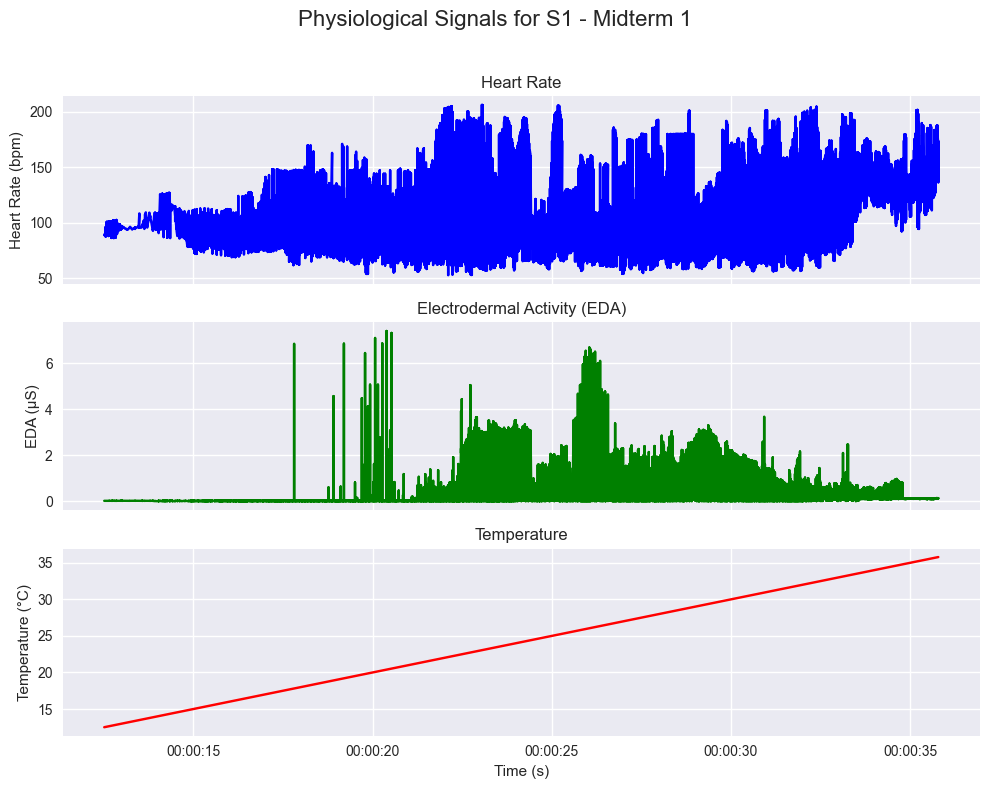

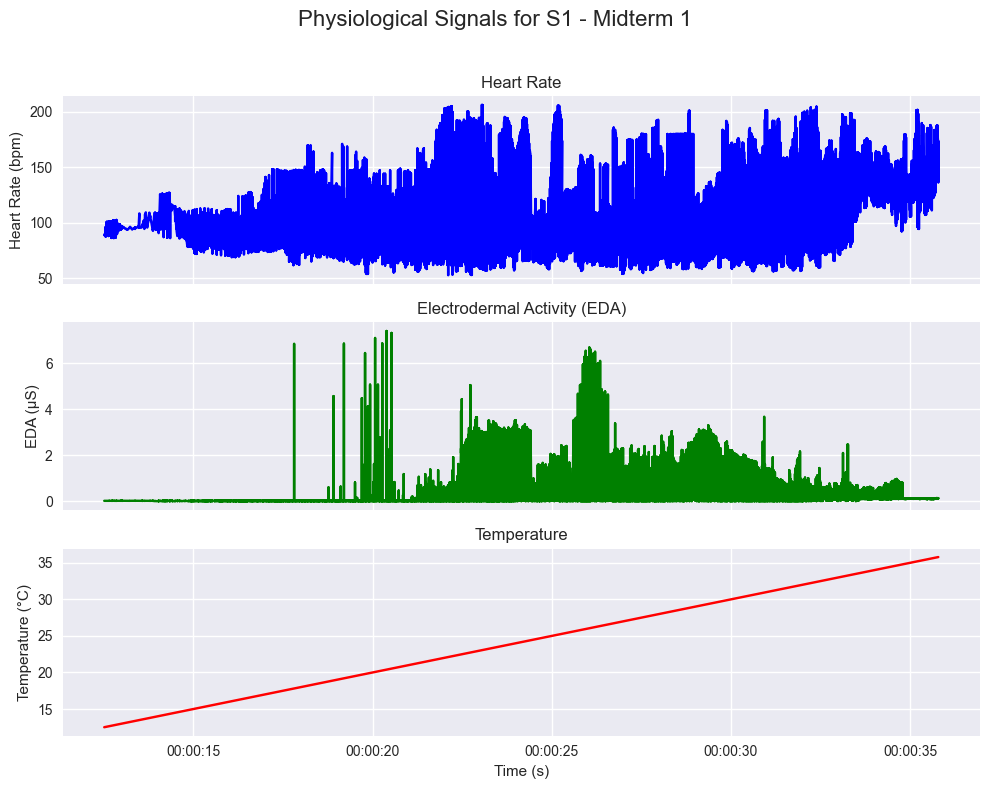

In [68]:
plot_physiological_signals(data, subject_id='S1', session='Midterm 1', output_dir='plots')


In [ ]:
def run_part1_exploration(data_dir='data/raw', output_dir='data/processed', plot_dir='plots'):

    # Step 1: Load the data
    print("Loading data...")
    data = load_data(data_dir)

    # Had issues with loading the data because I had multiple frames
    # Added these lines to merge them into one DataFrame for analysis
    # After redoing it, also realized I could have bypassed this step previously and returned the one DataFrame instead of the seaparate files...
    if isinstance(data, dict):
        # Merge all subject data into a single DataFrame
        all_data = []
        for subject_id, df in data.items():
            df['subject_id'] = subject_id # Double check subject ID
            all_data.append(df)
        data = pd.concat(all_data, ignore_index=True)  # Merge into one DataFrame
    else:
        pass

    # Step 2: Preprocess the data
    print("Preprocessing data...")
    processed_data = preprocess_data(data, output_dir)

    # Step 3: Plot physiological signals for each subject and session
    print("Generating plots...")
    for subject_id in data['subject_id'].unique():
        for session in data['session'].unique():
            subject_data = processed_data.get(subject_id) # Added this line for specific subject ID identification
            if subject_data is not None: # If the data is complete, continue
                plot_physiological_signals(subject_data, subject_id, session, plot_dir)

    print("Part 1: Exploration complete!")

In [ ]:
def run_part1_exploration(data_dir='data/raw', output_dir='data/processed', plot_dir='plots'):
    # Step 1: Load the data
    print("Loading data...")
    data = load_data(data_dir)
    
    # Step 2: Preprocess the data
    print("Preprocessing data...")
    processed_data = preprocess_data(data, output_dir)
    
    # Step 3: Plot physiological signals for each subject and session
    print("Generating plots...")
    for subject_id in data['subject_id'].unique():
        for session in data['session'].unique():
            plot_physiological_signals(processed_data, subject_id, session, plot_dir)
    
    print("Part 1: Exploration complete!")


Loading data...
Preprocessing data...
Outliers detected and removed:
248
Processed data saved to data/processed\S1_processed.csv
Outliers detected and removed:
84
Processed data saved to data/processed\S10_processed.csv
Outliers detected and removed:
1176
Processed data saved to data/processed\S2_processed.csv
Outliers detected and removed:
256
Processed data saved to data/processed\S3_processed.csv
Outliers detected and removed:
596
Processed data saved to data/processed\S4_processed.csv
Outliers detected and removed:
284
Processed data saved to data/processed\S5_processed.csv
Outliers detected and removed:
938
Processed data saved to data/processed\S6_processed.csv
Outliers detected and removed:
6
Processed data saved to data/processed\S7_processed.csv
Outliers detected and removed:
137
Processed data saved to data/processed\S8_processed.csv
Outliers detected and removed:
544
Processed data saved to data/processed\S9_processed.csv
Generating plots...
Plot saved to: data/processed\S1_

C:\Users\jelou\AppData\Local\Temp\ipykernel_7816\277107121.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)


Plot saved to: data/processed\S6_Final_signals.png
Plot saved to: data/processed\S7_Midterm 1_signals.png
Plot saved to: data/processed\S7_Midterm 2_signals.png
Plot saved to: data/processed\S7_Final_signals.png
Plot saved to: data/processed\S8_Midterm 1_signals.png
Plot saved to: data/processed\S8_Midterm 2_signals.png
Plot saved to: data/processed\S8_Final_signals.png
Plot saved to: data/processed\S9_Midterm 1_signals.png
Plot saved to: data/processed\S9_Midterm 2_signals.png
Plot saved to: data/processed\S9_Final_signals.png
Part 1: Exploration complete!


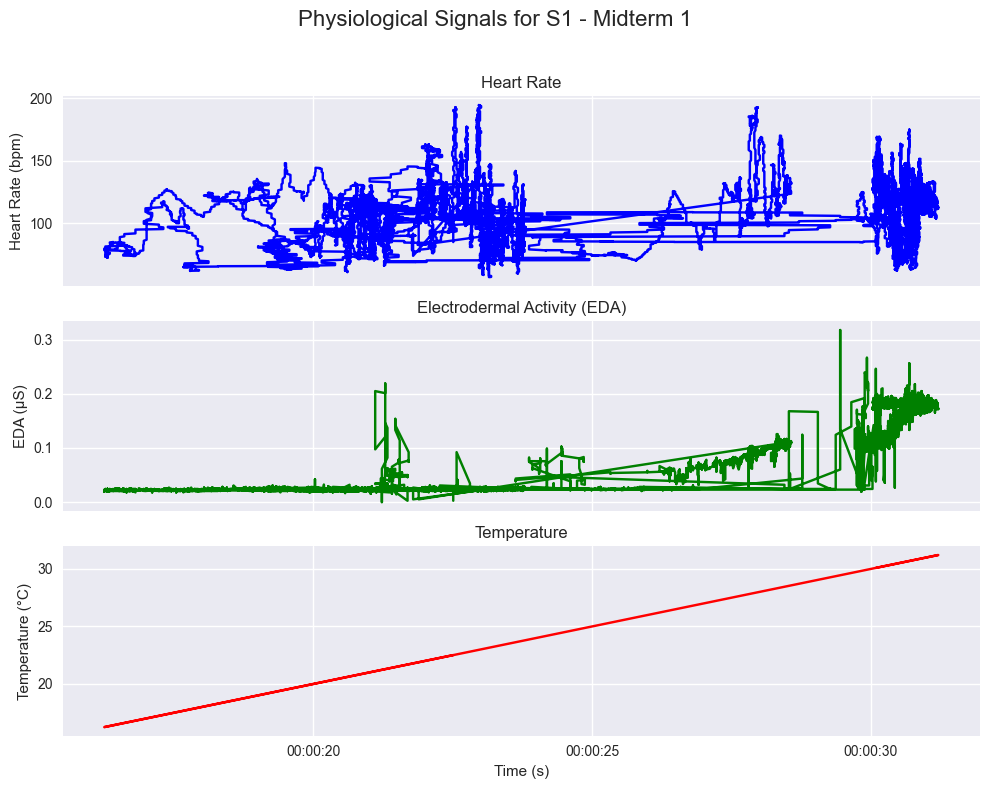

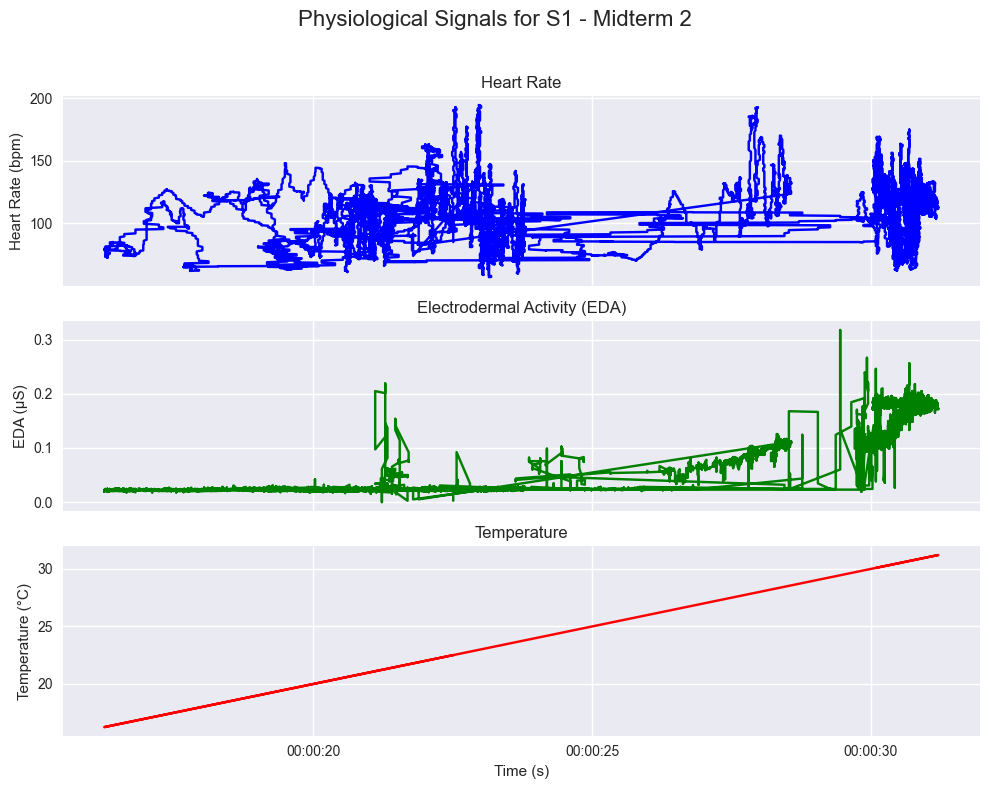

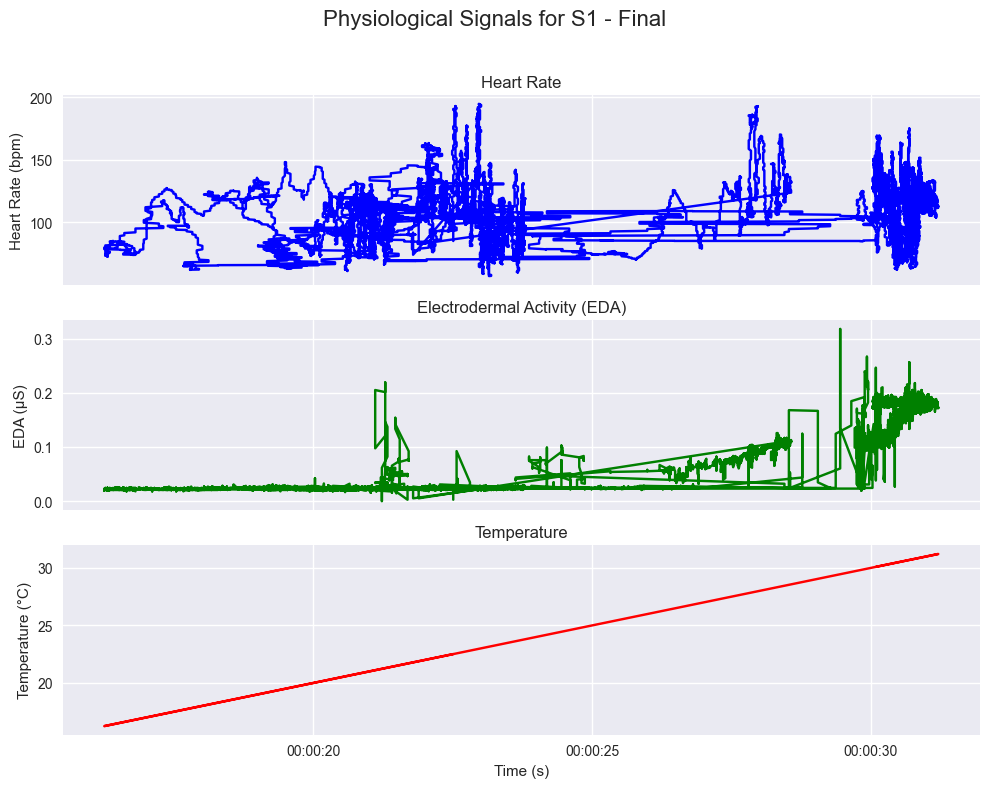

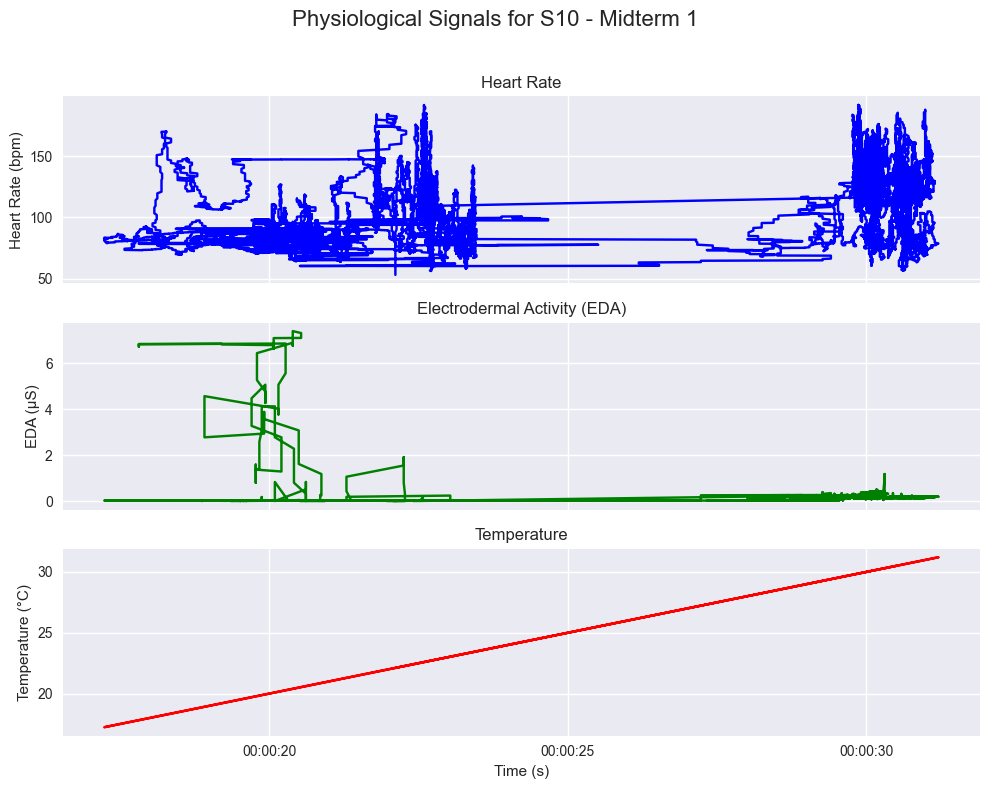

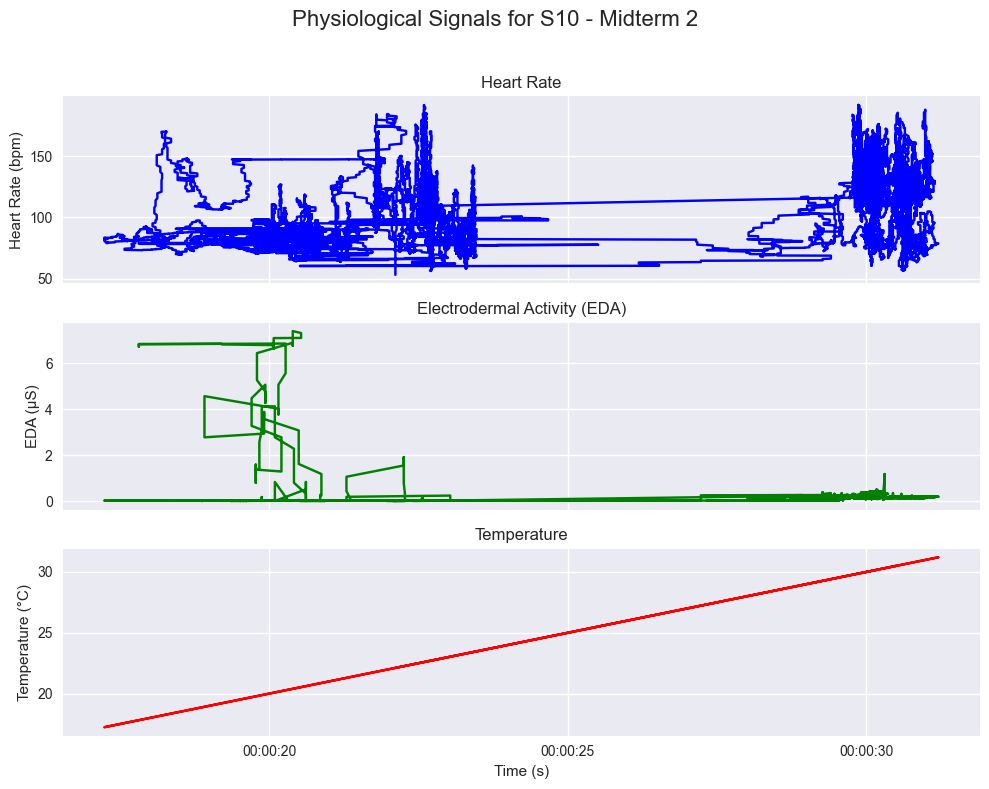

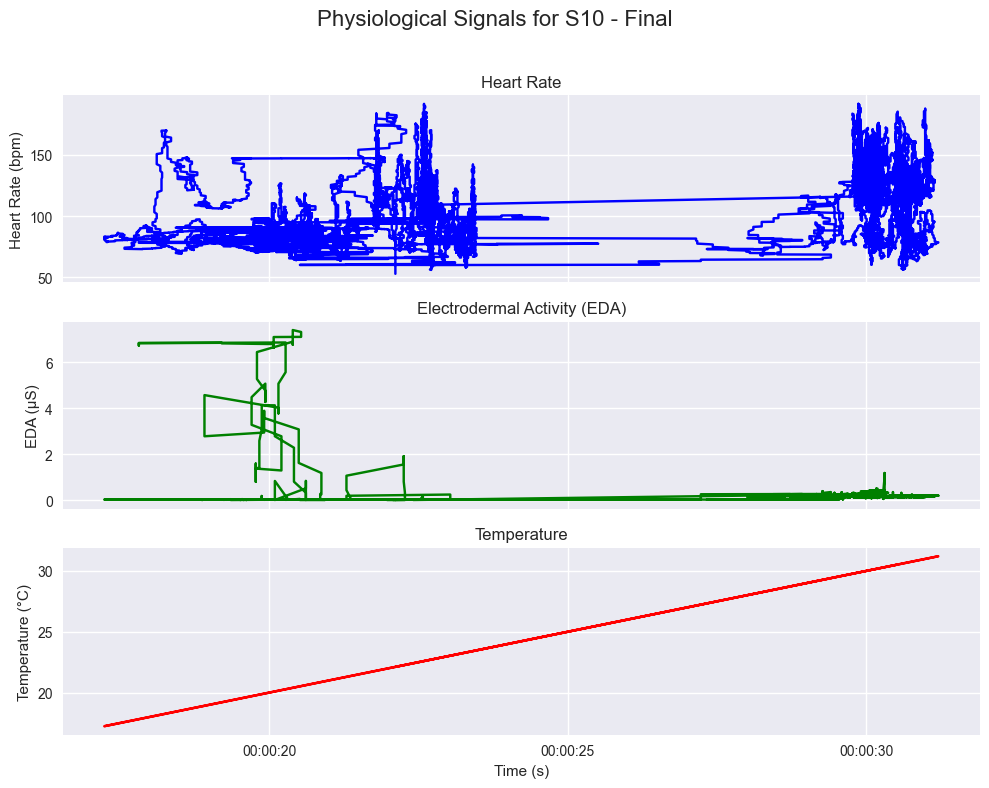

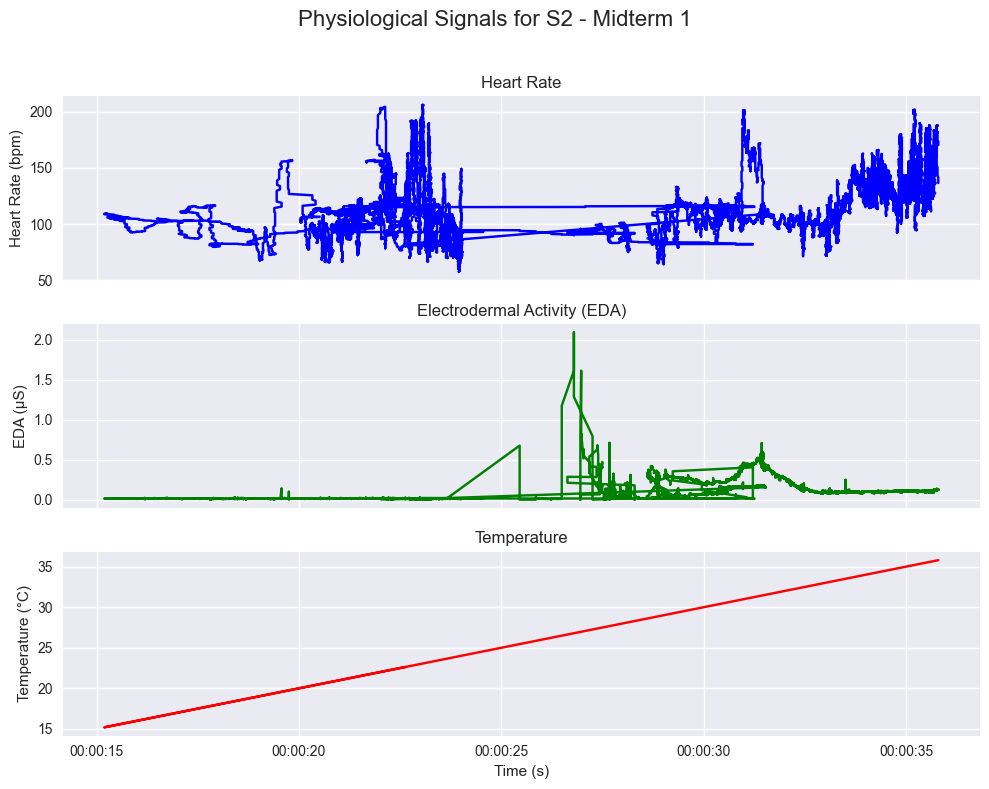

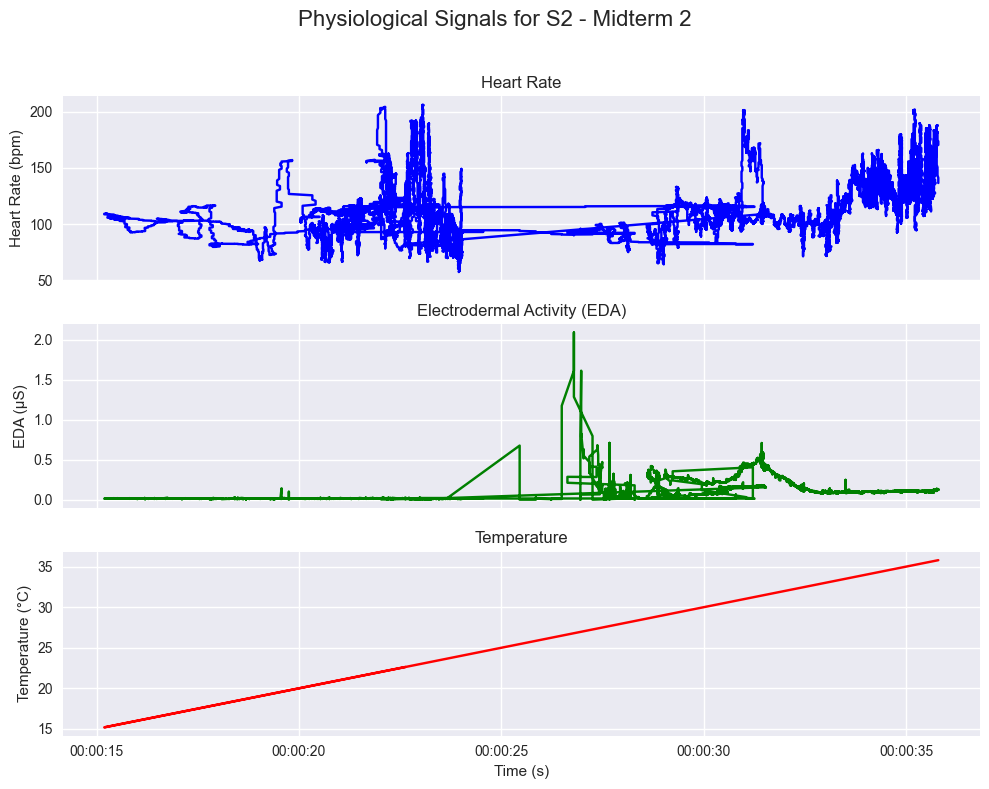

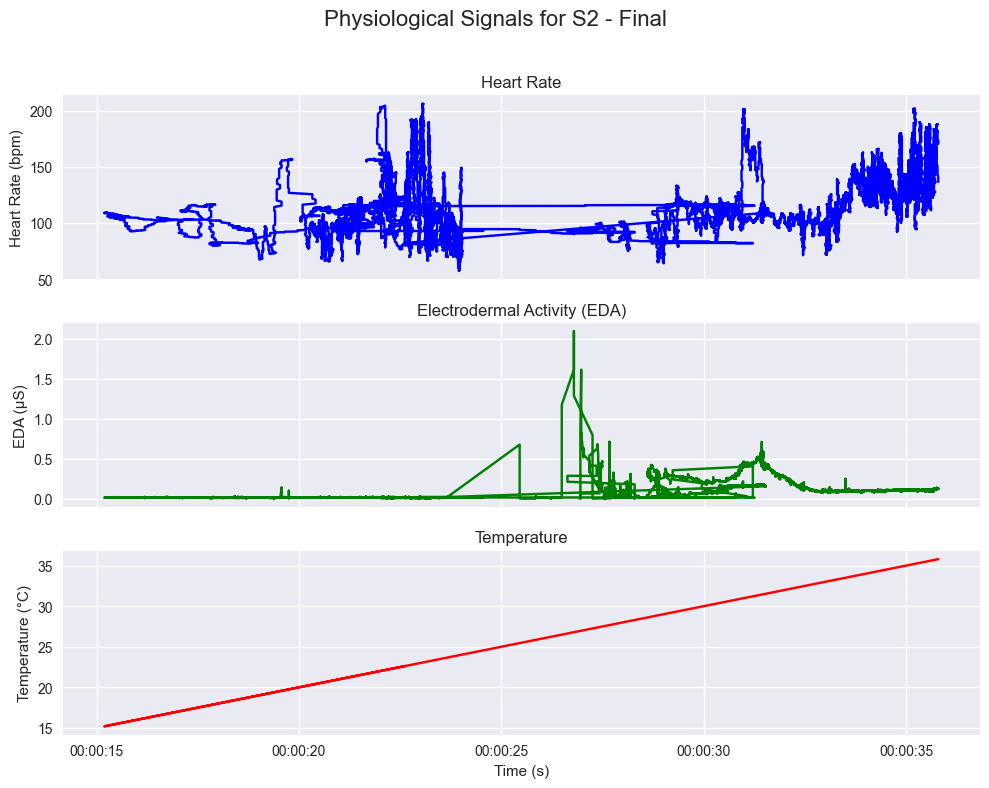

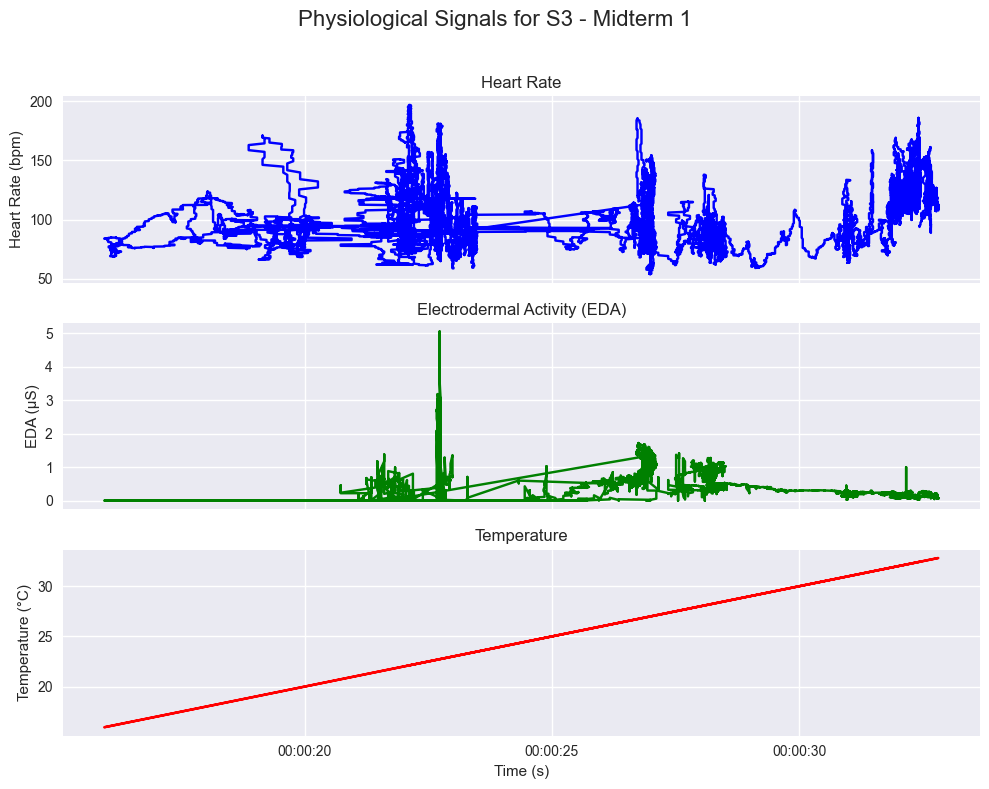

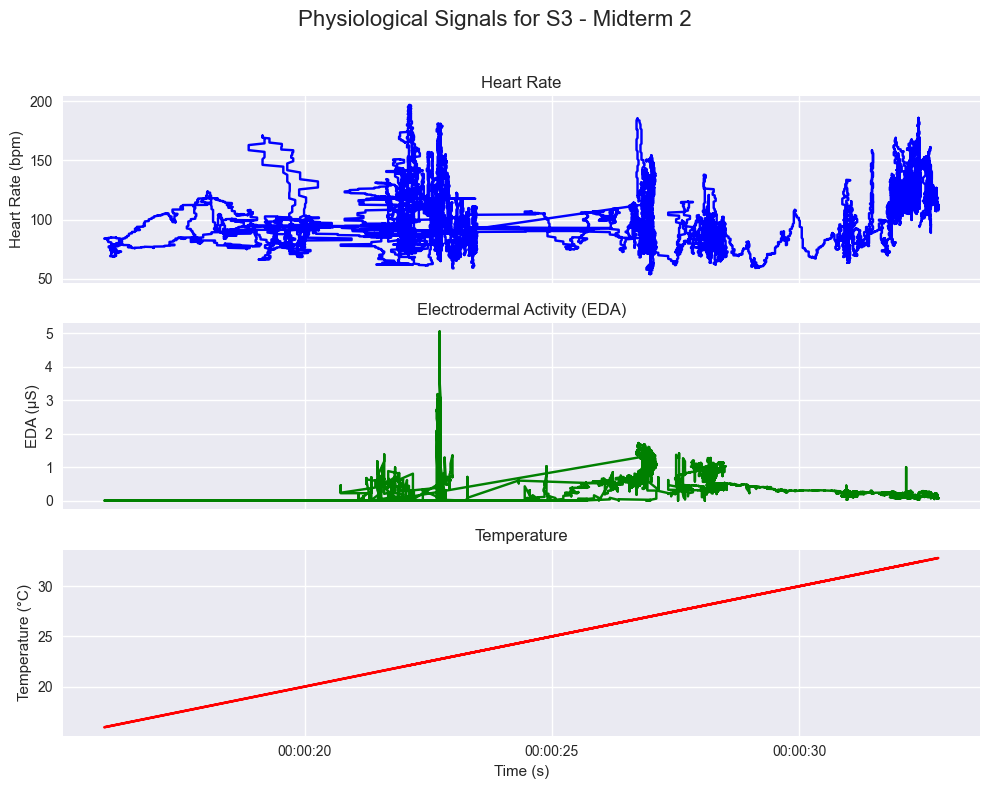

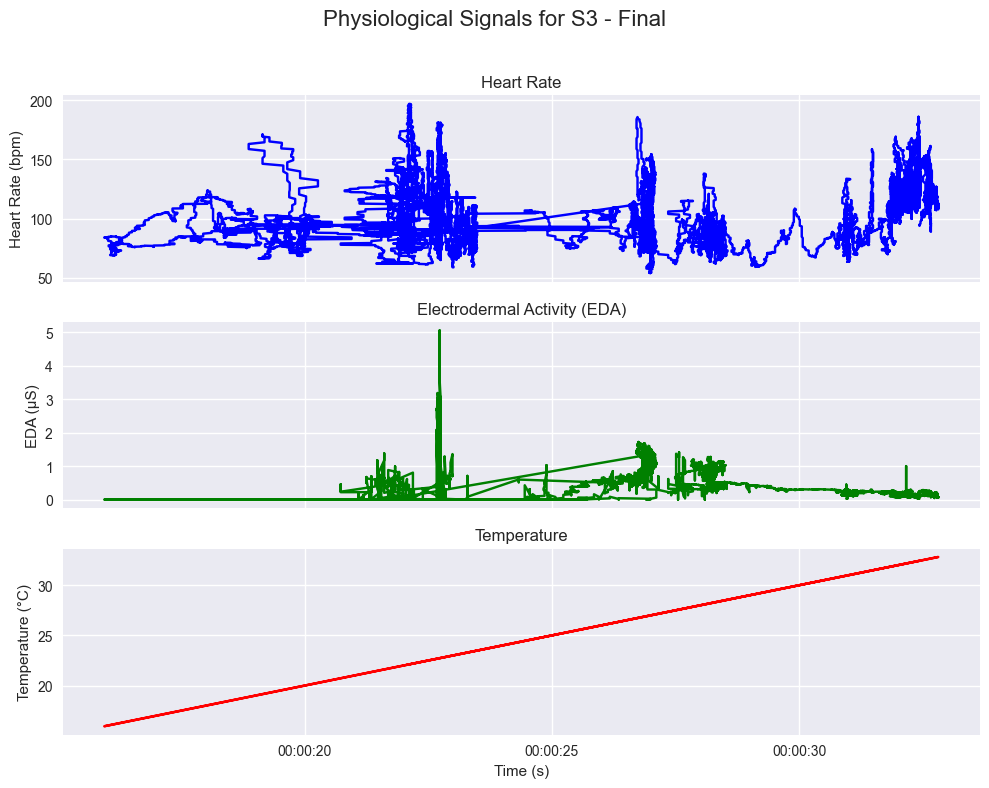

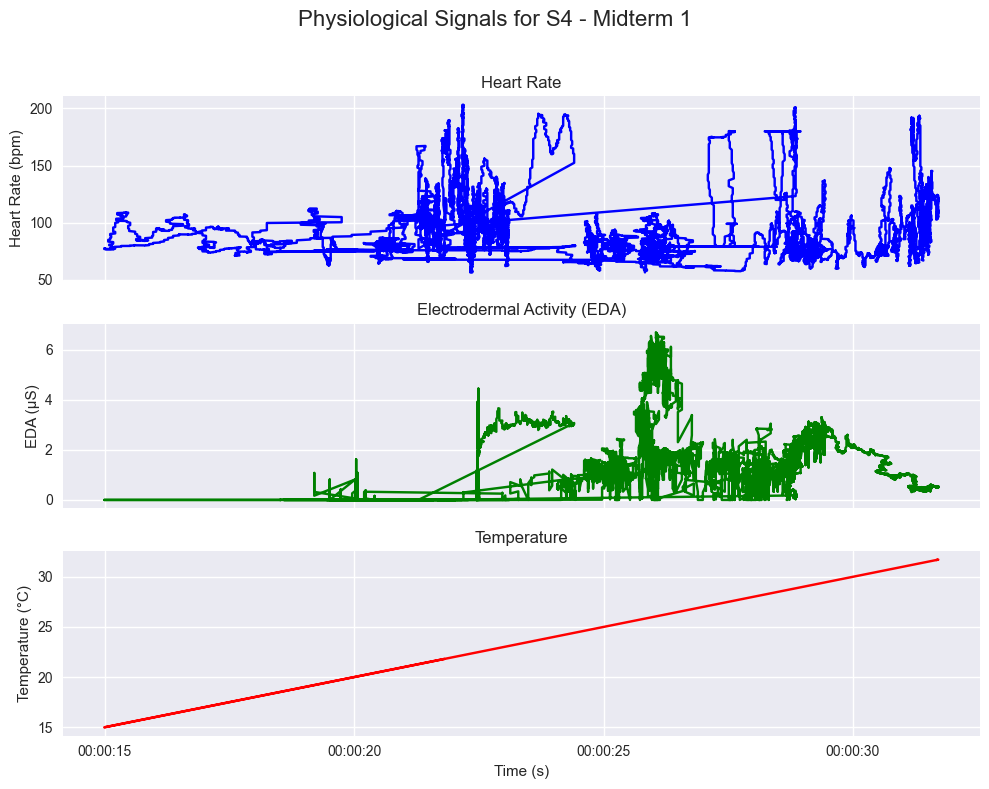

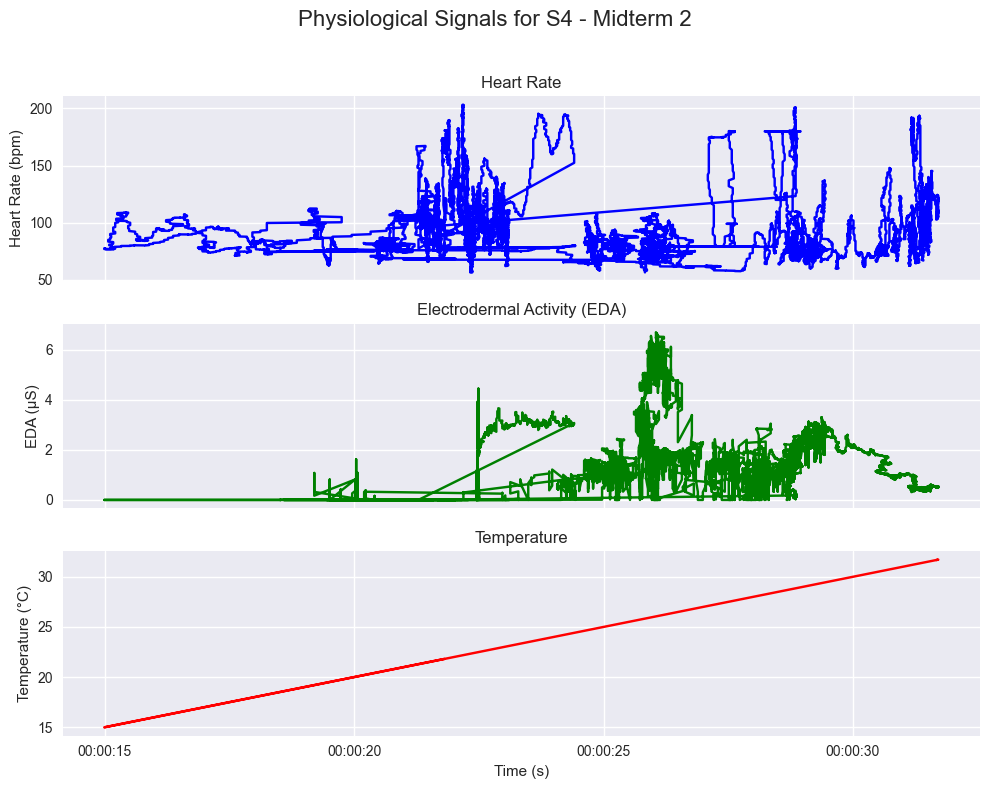

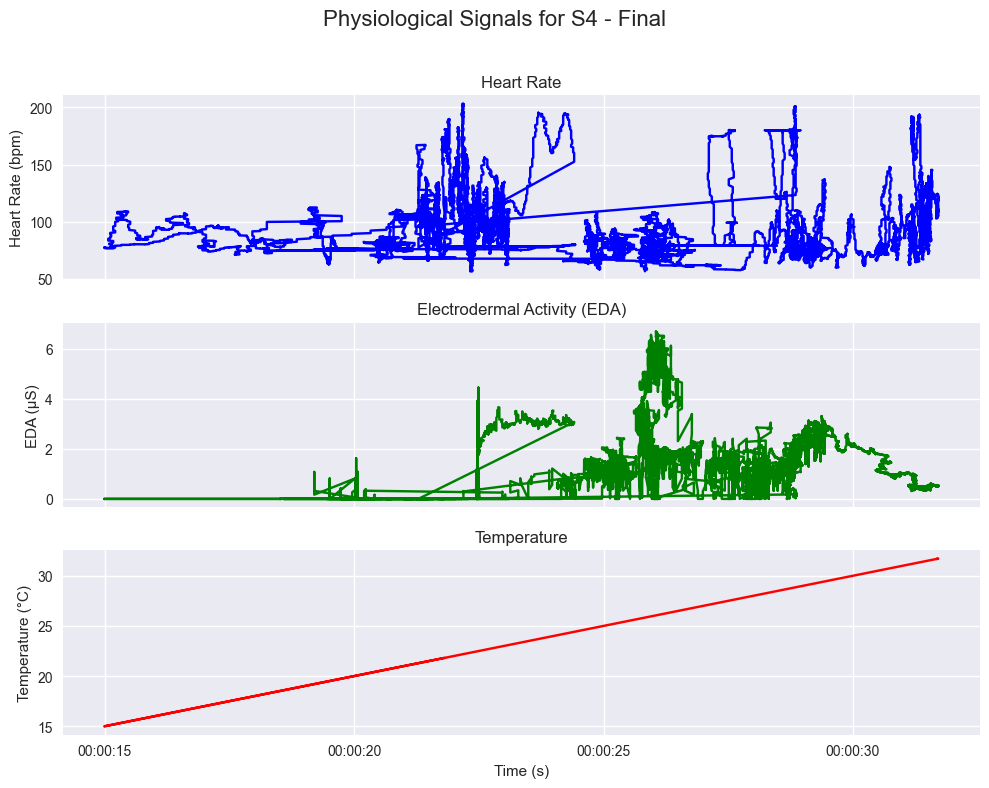

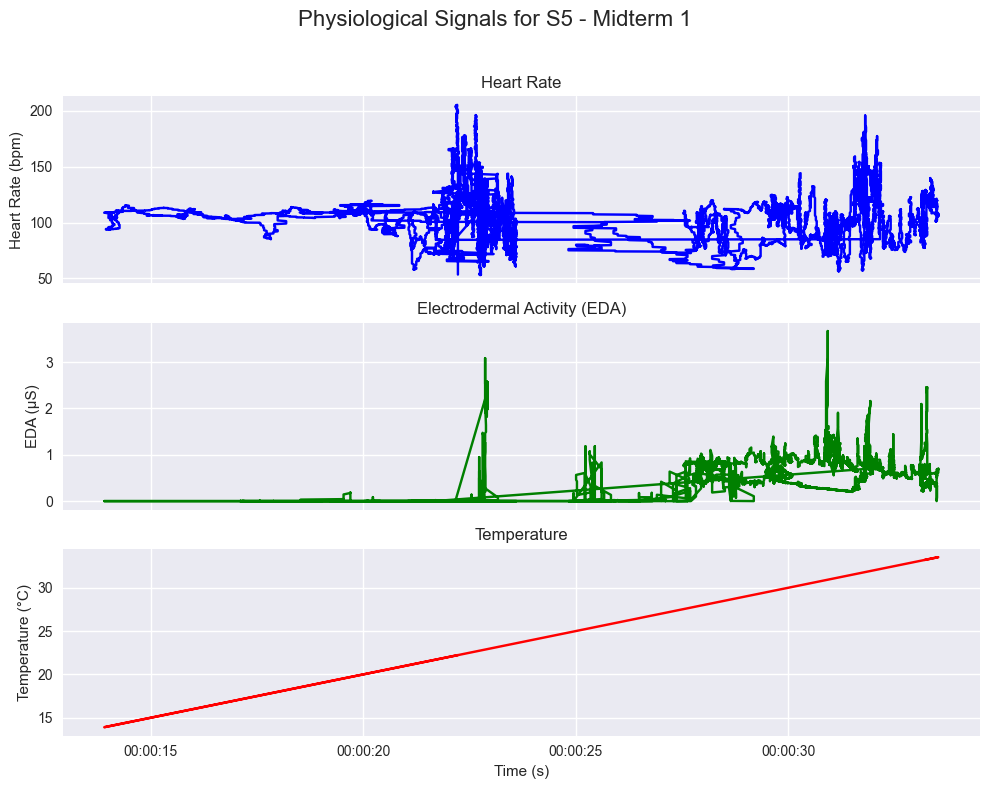

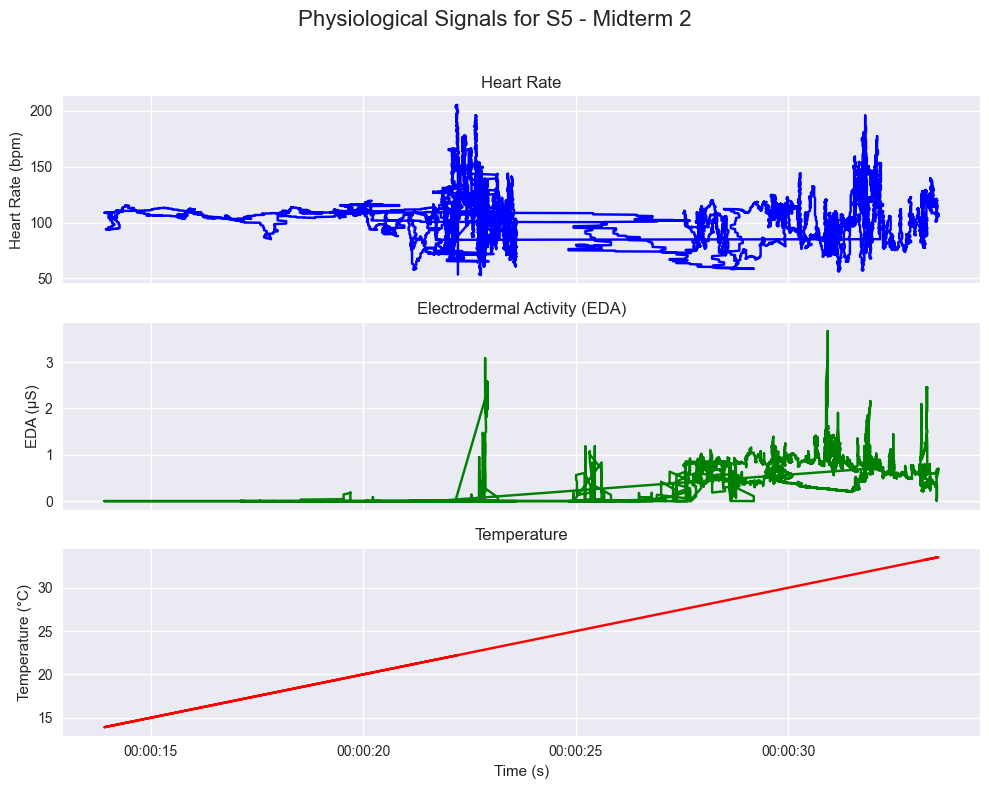

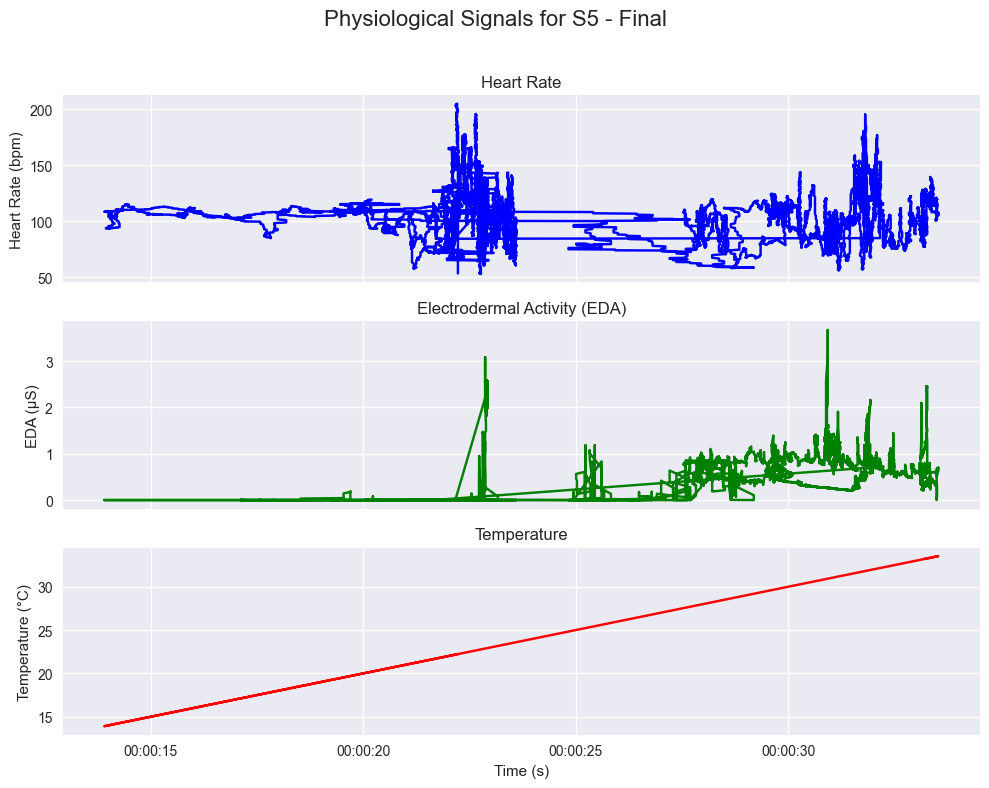

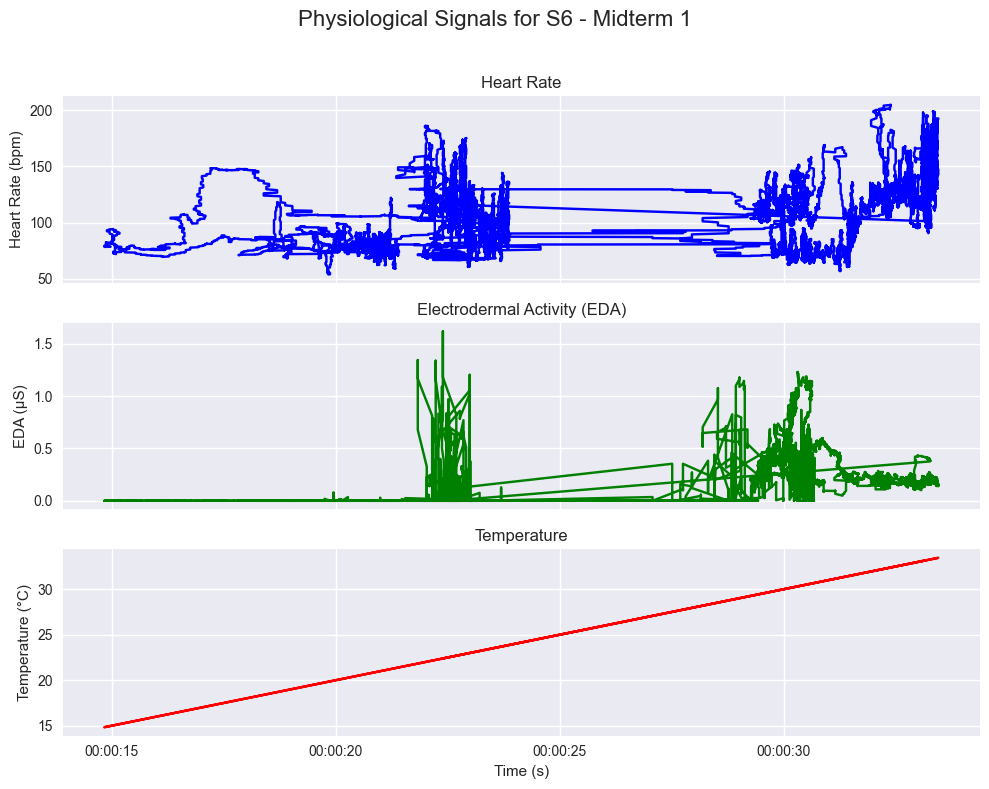

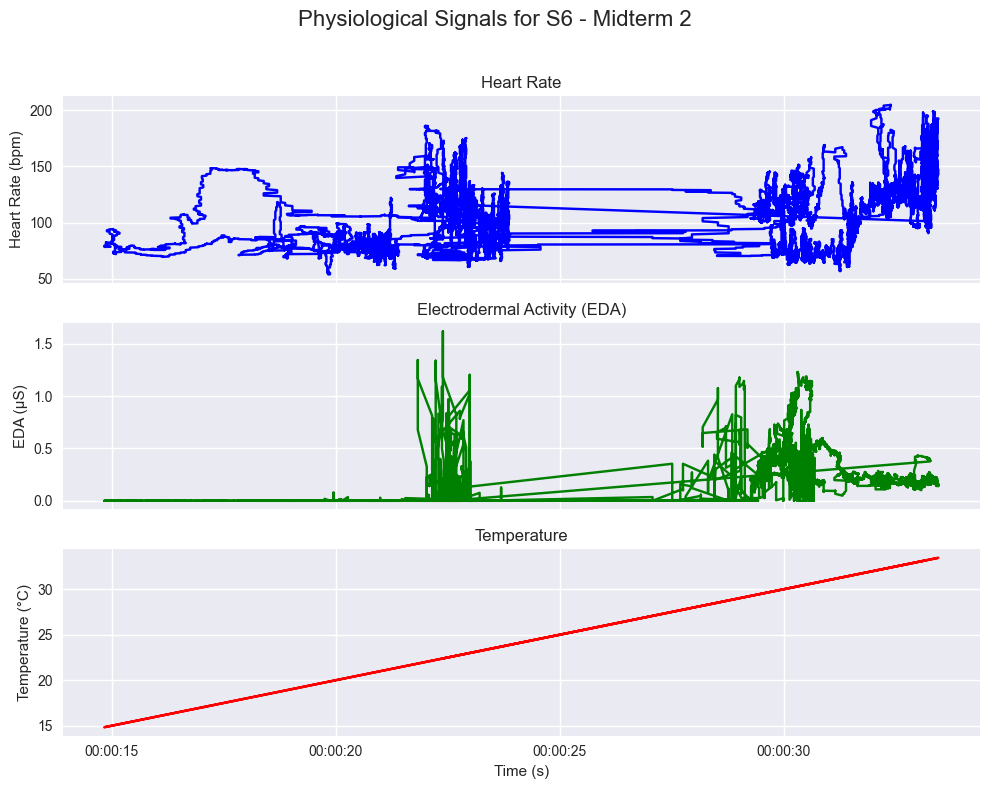

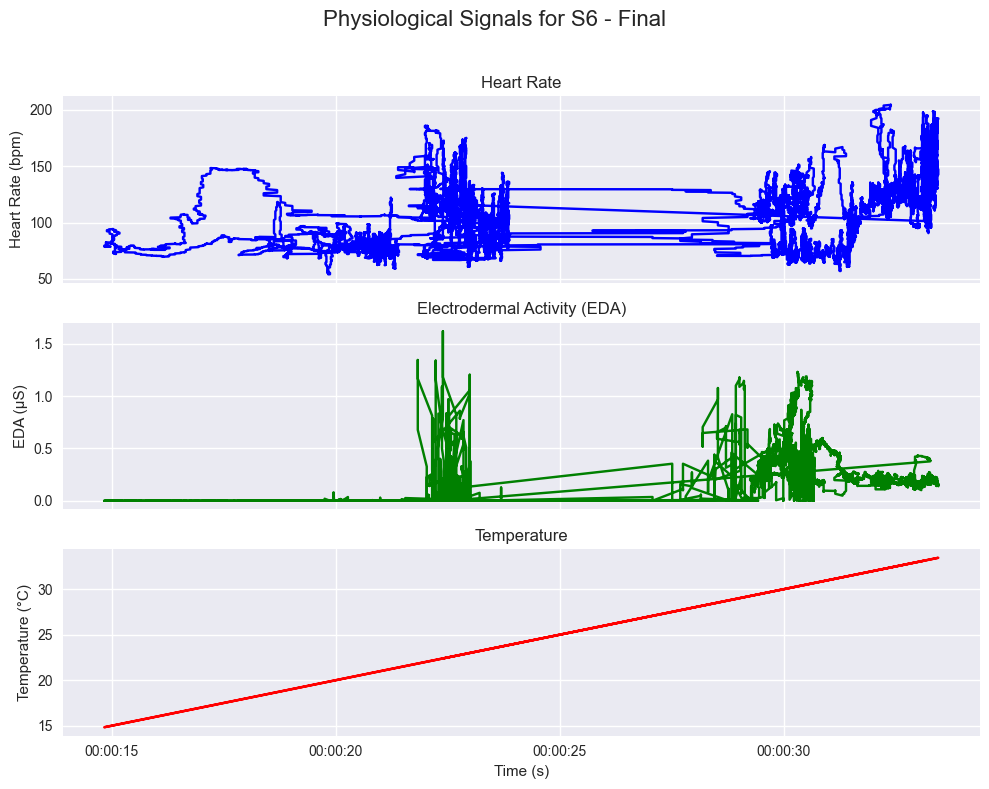

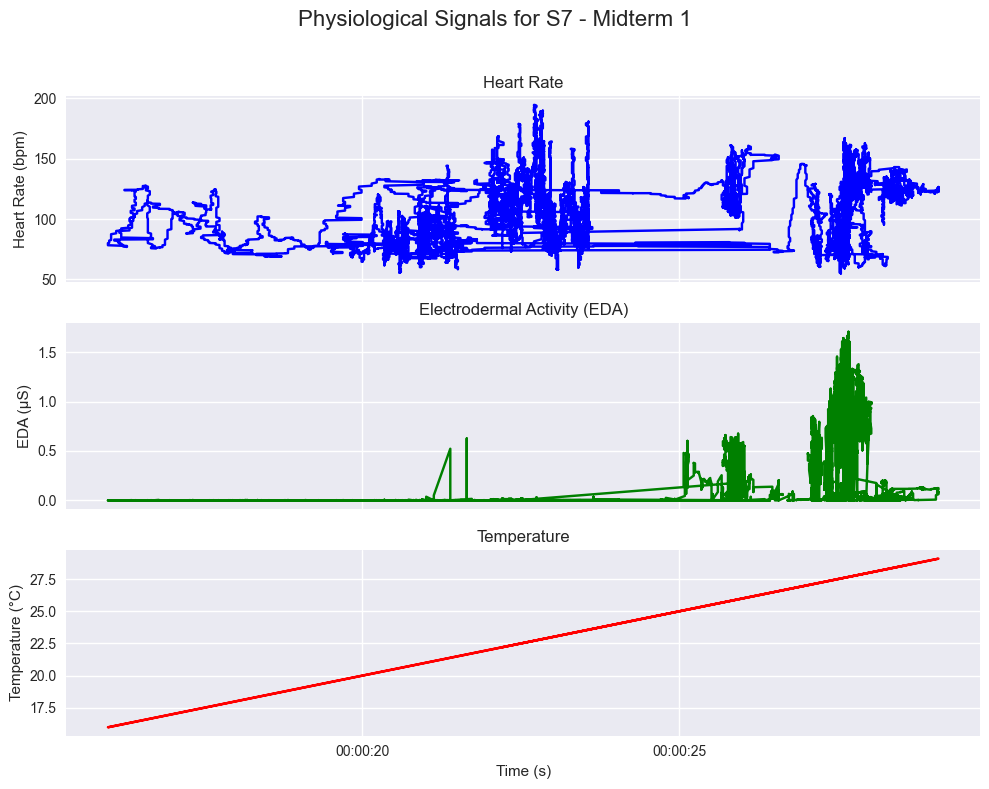

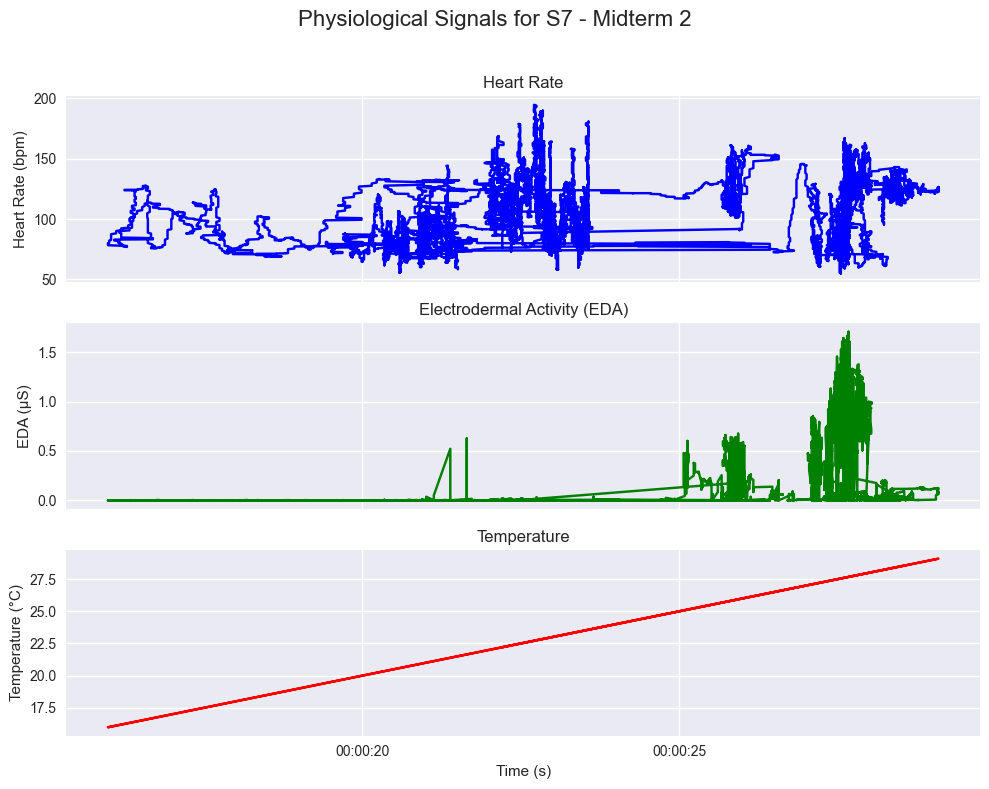

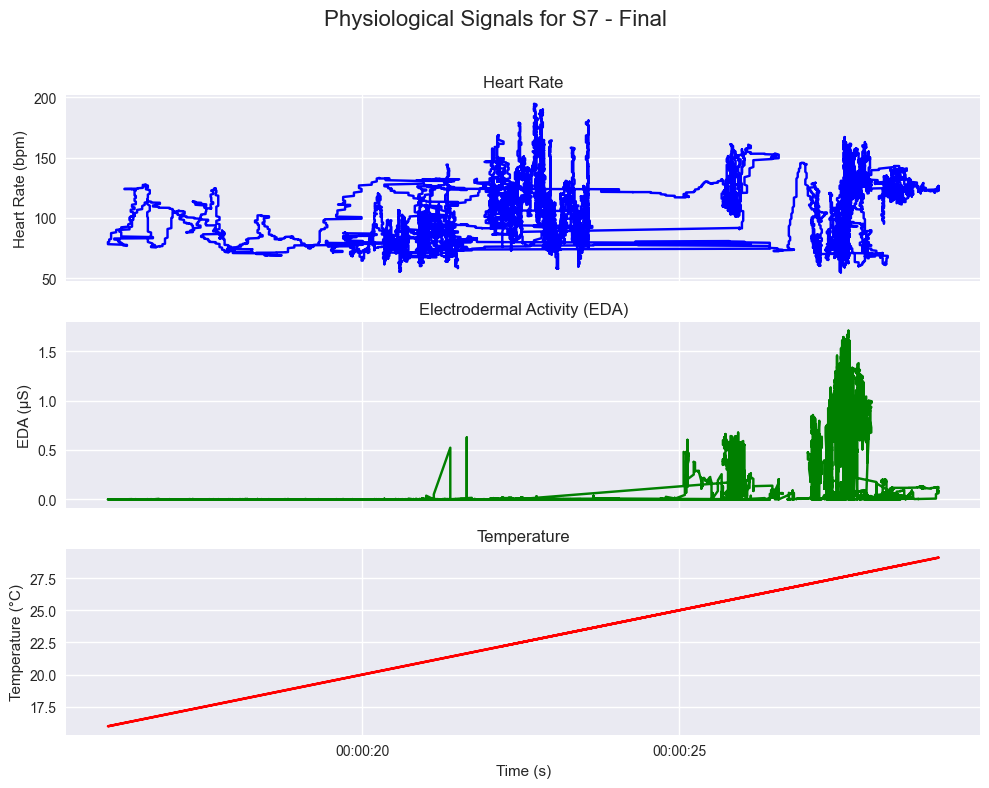

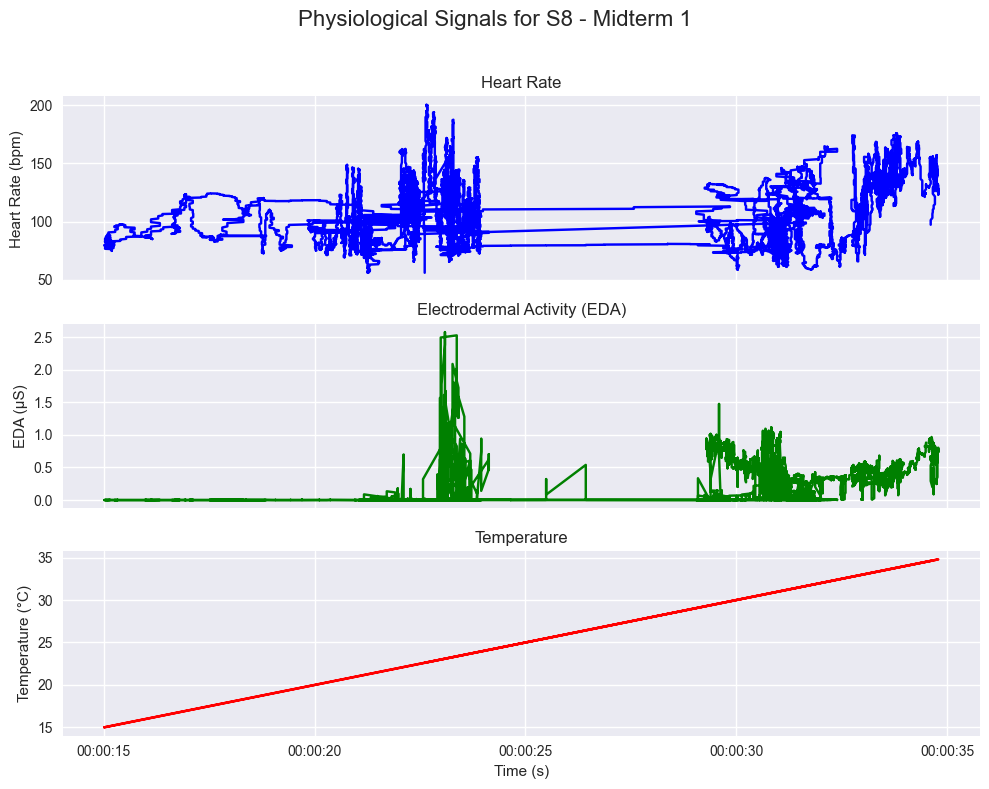

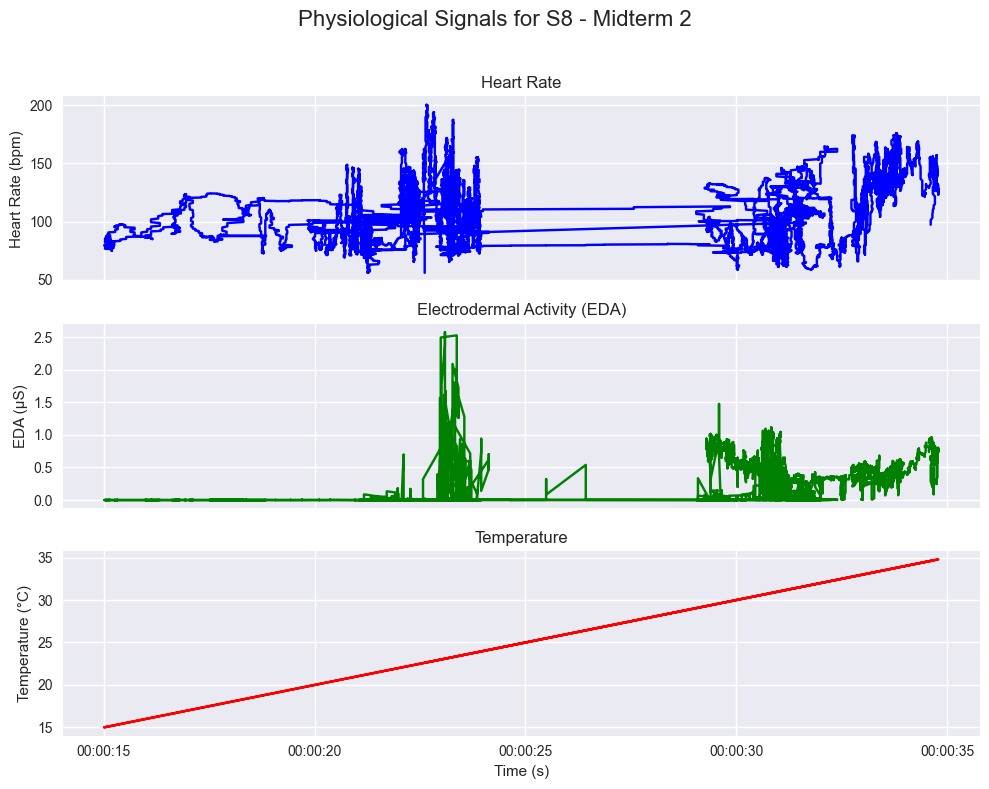

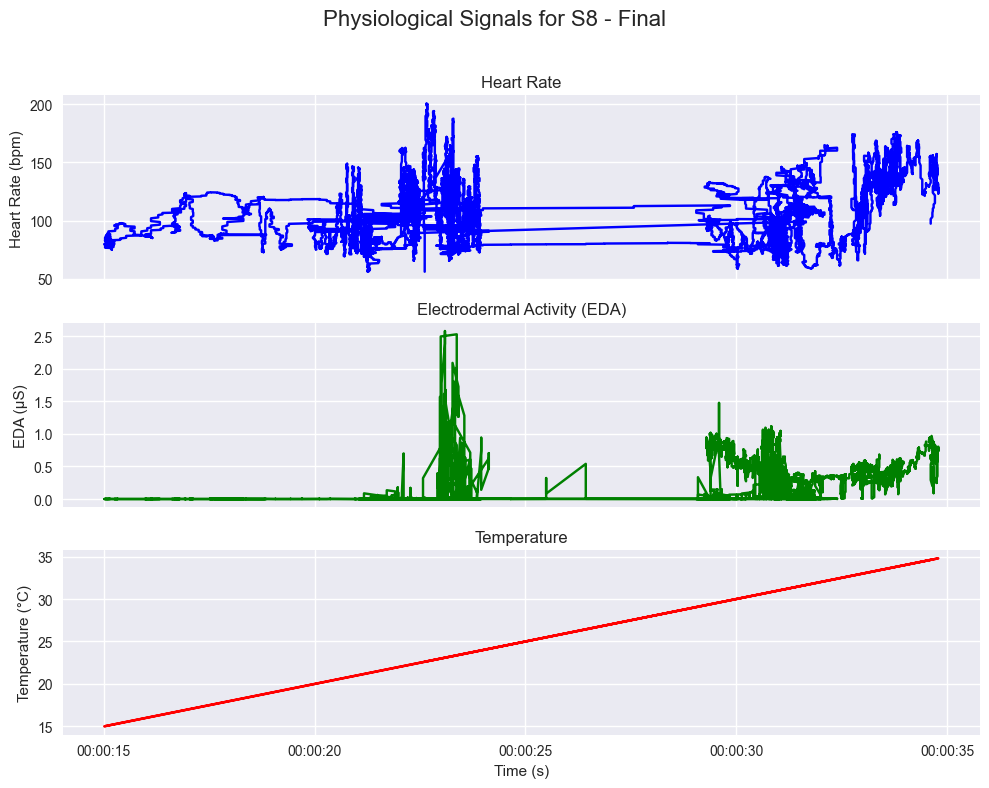

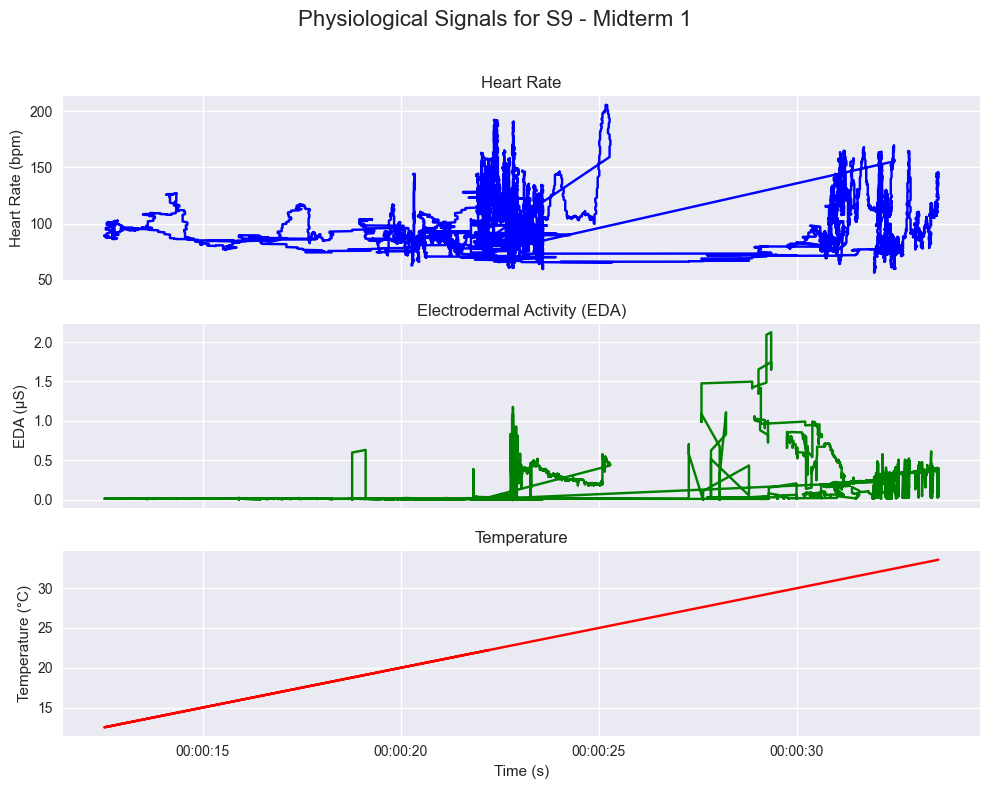

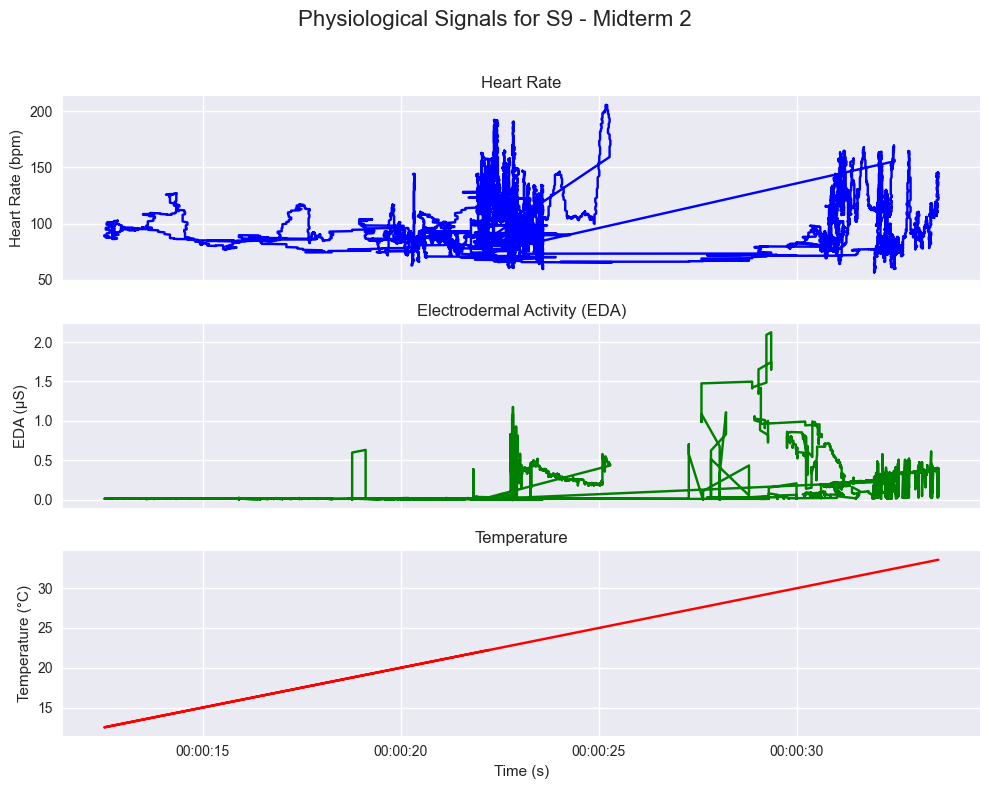

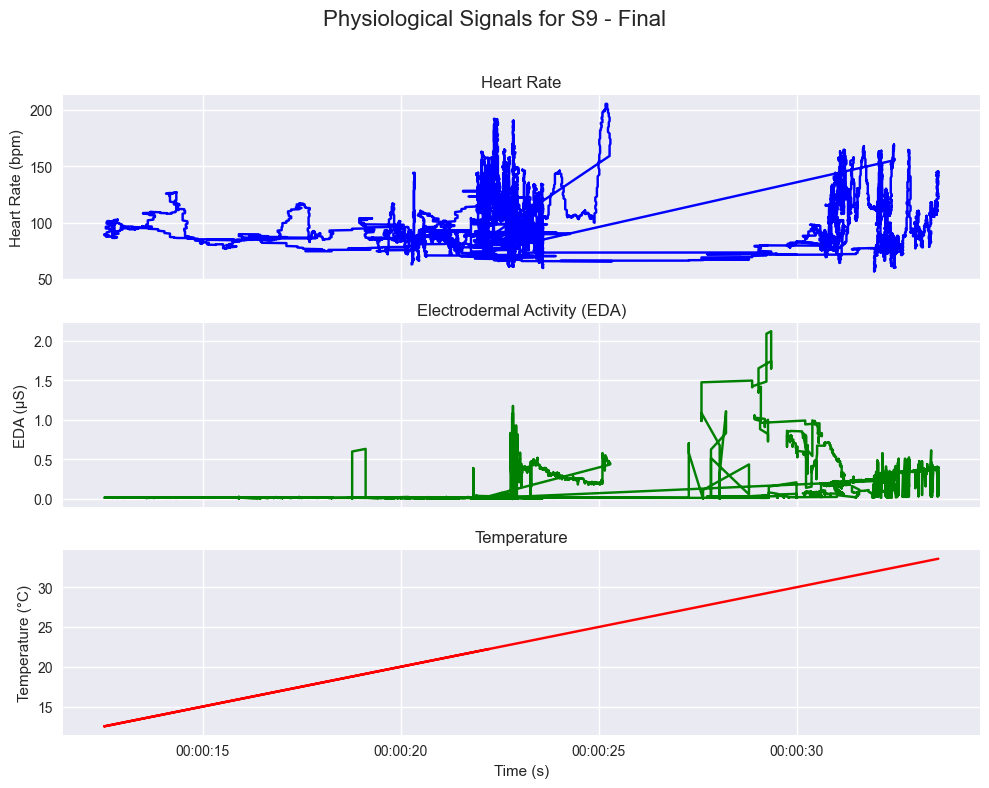

In [75]:
run_part1_exploration(data_dir='data/raw', output_dir='data/processed', plot_dir='plots')